# TensorFlow for Deep Learning - U-Net and Transfer Learning for Semantic Segmentation

Credits - [U-Net for Semantic Segmentation](https://www.youtube.com/playlist?list=PLZsOBAyNTZwbR08R959iCvYT3qzhxvGOE/)

<img src="images/TF_UNet1.png" width="700"/>
<img src="images/TF_UNet3.png" width="700"/>


## Data Processing

In [8]:
import os
import numpy as np
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [9]:
RANDOM_STATE = 42
np.random.seed = RANDOM_STATE

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'data/data-science-bowl-2018/stage1_train/'
TEST_PATH = 'data/data-science-bowl-2018/stage1_test/'

In [10]:
processData = False

if processData:
    train_ids = next(os.walk(TRAIN_PATH))[1]
    test_ids = next(os.walk(TEST_PATH))[1]

    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    # counter = 1

    print('Resizing training images and masks')
    for n, name in tqdm(enumerate(train_ids), total=len(train_ids)):   
        path = TRAIN_PATH + name
        img = imread(path + '/images/' + name + '.png')[:,:,:IMG_CHANNELS]  
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                        preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)  
        Y_train[n] = mask  
        # counter += 1
        # if counter==100: break

    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

    print('Resizing testing images')
    for n, name in tqdm(enumerate(test_ids), total=len(test_ids)):   
        path = TEST_PATH + name
        img = imread(path + '/images/' + name + '.png')[:,:,:IMG_CHANNELS]  
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img

    from pickle import dump

    dump(X_train, open(TRAIN_PATH+'X_train.pkl', 'wb'))
    dump(Y_train, open(TRAIN_PATH+'Y_train.pkl', 'wb'))
    dump(X_test, open(TEST_PATH+'X_train.pkl', 'wb'))

else:
    from pickle import load

    X_train = load(open(TRAIN_PATH+'X_train.pkl', 'rb'))
    Y_train = load(open(TRAIN_PATH+'Y_train.pkl', 'rb'))
    X_test = load(open(TEST_PATH+'X_test.pkl', 'rb'))

print(X_train.shape, Y_train.shape, X_test.shape)

(670, 128, 128, 3) (670, 128, 128, 1) (65, 128, 128, 3)


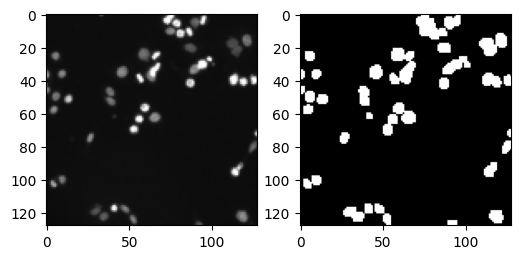

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,4), dpi=100)

ax[0].imshow(X_train[5])
ax[1].imshow(Y_train[5], cmap='gray');

In [12]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_Y, val_Y = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

print(train_X.shape, val_X.shape, train_Y.shape, val_Y.shape)

(536, 128, 128, 3) (134, 128, 128, 3) (536, 128, 128, 1) (134, 128, 128, 1)


## U-Net Model

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, MaxPool2D, Lambda, Dropout

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, MaxPool2D, Lambda, Dropout

inputs = Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
s = Lambda(lambda x: x/255.)(inputs)

# Contraction Path
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c1')(c1)
p1 = MaxPool2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c2')(c2)
p2 = MaxPool2D((2, 2))(c2)
 
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c3')(c3)
p3 = MaxPool2D((2, 2))(c3)
 
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c4')(c4)
p4 = MaxPool2D(pool_size=(2, 2))(c4)
 
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c5')(c5)

#Expansive path 
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c6')(c6)
 
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c7')(c7)
 
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c8')(c8)
 
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='c9')(c9)
 
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 16) 0           conv2d_10[0][0]                  
____________________________________________________________________________________________

In [18]:
import tensorflow.keras.callbacks as cbs

callbacks = [cbs.ModelCheckpoint('modules/model_for_nuclei.h5', save_best_only=True),
             cbs.EarlyStopping(patience=2, monitor='val_loss')]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
results = model.fit(train_X, train_Y, validation_split=0.1, batch_size=8, epochs=25, 
                    validation_batch_size=8, callbacks=callbacks)

Epoch 1/25
61/61 [==============================] - 62s 974ms/step - loss: 0.5898 - accuracy: 0.8057 - val_loss: 0.3877 - val_accuracy: 0.7968
Epoch 2/25
61/61 [==============================] - 56s 912ms/step - loss: 0.2850 - accuracy: 0.8578 - val_loss: 0.2554 - val_accuracy: 0.8980
Epoch 3/25
61/61 [==============================] - 57s 926ms/step - loss: 0.1730 - accuracy: 0.9329 - val_loss: 0.1782 - val_accuracy: 0.9294
Epoch 4/25
61/61 [==============================] - 52s 850ms/step - loss: 0.1398 - accuracy: 0.9455 - val_loss: 0.1795 - val_accuracy: 0.9385
Epoch 5/25
61/61 [==============================] - 52s 844ms/step - loss: 0.1271 - accuracy: 0.9509 - val_loss: 0.1299 - val_accuracy: 0.9488
Epoch 6/25
61/61 [==============================] - 59s 961ms/step - loss: 0.1197 - accuracy: 0.9532 - val_loss: 0.1374 - val_accuracy: 0.9436
Epoch 7/25
61/61 [==============================] - 54s 880ms/step - loss: 0.1138 - accuracy: 0.9556 - val_loss: 0.1215 - val_accuracy: 0.9507

In [19]:
from sklearn.metrics import accuracy_score, f1_score

train_pred = model.predict(train_X, verbose=1, batch_size=8) > 0.5
val_pred = model.predict(val_X, verbose=1, batch_size=8) > 0.5

print(f"Val accuracy = {accuracy_score(val_Y.reshape(-1), val_pred.reshape(-1))}")
print(f"Val f1_score = {f1_score(val_Y.reshape(-1), val_pred.reshape(-1))}")

17/17 [==============================] - 2s 115ms/step
Val accuracy = 0.9645891331914646
Val f1_score = 0.9138576945024626


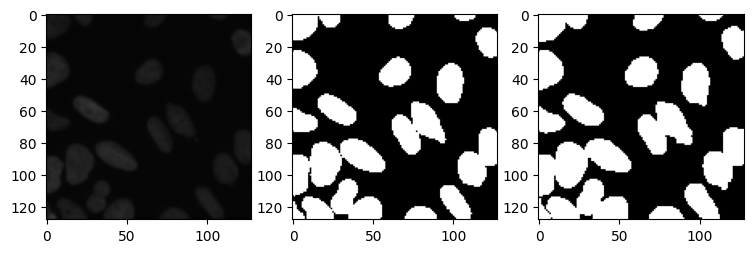

In [20]:
idx = np.random.randint(0, len(val_pred))

img_X, img_Y = val_X[idx], np.squeeze(val_Y[idx])
img_Y_pred = np.squeeze(val_pred[idx])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,4), dpi=100)
ax[0].imshow(val_X[idx])
ax[1].imshow(img_Y*img_Y_pred, cmap='gray')
ax[2].imshow(np.maximum(img_Y, img_Y_pred), cmap='gray');

### Mean Average Precision (mAP)

In [21]:
def mAP(X_, Y_, pred_):
    mAP = 0.0
    thresholds = (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95)

    for idx in range(len(X_)):
        
        img_IoU = 0.0 
        img_X, img_Y = X_[idx], Y_[idx]
        img_Y_pred = pred_[idx]
        img_IoU_t = np.sum(img_Y*img_Y_pred)/(np.maximum(img_Y, img_Y_pred)).sum()
        for t in thresholds:
            if img_IoU_t >= t:
                img_IoU += (img_IoU_t)
        img_IoU /= len(thresholds)

        mAP += img_IoU  
    return mAP/len(X_)

print(f"Train U-Net IoU = {mAP(train_X, train_Y, train_pred)}")
print(f"Valid U-Net IoU = {mAP(val_X, val_Y, val_pred)}")

Train U-Net IoU = 0.6187813252819238
Valid U-Net IoU = 0.6408321564895909


## Transfer Learning using VGG16

In [22]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
vgg_model.trainable = False

# we need to chop-off vgg at 'block1_conv2' to match the Y_train.shape
new_model = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('block1_conv2').output)
new_model.summary(), train_Y.shape[1:]

58900480/58889256 [==============================] - 5s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


(None, (128, 128, 1))

In [23]:
train_features = new_model.predict(train_X)
val_features = new_model.predict(val_X)
print(train_features.shape, val_features.shape)

(536, 128, 128, 64) (134, 128, 128, 64)


### Random Forest

In [24]:
# # For RF every pixel in every image is an instance with 3 features
# # This doesn't work that well
# train_features_rf = train_X.reshape(-1, train_X.shape[-1])
# val_features_rf = val_X.reshape(-1, val_X.shape[-1])

# For RF every pixel in every image is an instance with 64 features
# This works well as we increase the no. of features
train_features_rf = train_features.reshape(-1, train_features.shape[-1])
val_features_rf = val_features.reshape(-1, val_features.shape[-1])

train_Y_rf = train_Y.reshape(-1)
val_Y_rf = val_Y.reshape(-1)

print(train_features_rf.shape, train_Y_rf.shape, val_features_rf.shape, val_Y_rf.shape)

(8781824, 64) (8781824,) (2195456, 64) (2195456,)


In [25]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(50, random_state=RANDOM_STATE, min_samples_split=10, n_jobs=-1)
rf.fit(train_features_rf[:], train_Y_rf[:])

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

train_pred = rf.predict(train_features_rf)
val_pred = rf.predict(val_features_rf)

print(f"Val accuracy = {accuracy_score(val_Y_rf, val_pred)}")
print(f"Val f1_score = {f1_score(val_Y_rf, val_pred)}")

Val accuracy = 0.965576171875
Val f1_score = 0.9183567646048444


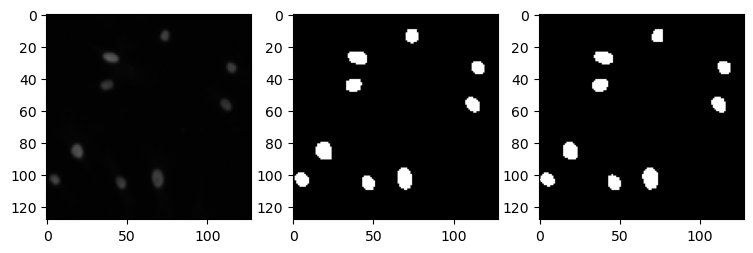

In [ ]:
idx = np.random.randint(0, len(val_X))

img_X, img_Y = val_X[idx], val_Y[idx]
img_Y_pred = val_pred.reshape(len(val_X), IMG_WIDTH, IMG_HEIGHT, 1)[idx]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,4), dpi=100)
ax[0].imshow(val_X[idx])
ax[1].imshow(img_Y, cmap='gray')
ax[2].imshow(img_Y_pred, cmap='gray');

### Mean Average Precision (map)

In [ ]:
def mAP(Y_, pred_):
    mAP = 0.0
    thresholds = (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95)

    for idx in range(len(Y_)):
        
        img_IoU = 0.0 
        img_Y = Y_[idx]
        img_Y_pred = pred_.reshape(len(Y_), IMG_WIDTH, IMG_HEIGHT, 1)[idx]
        img_IoU_t = np.sum(img_Y*img_Y_pred)/(np.maximum(img_Y, img_Y_pred)).sum()
        for t in thresholds:
            if img_IoU_t >= t:
                img_IoU += (img_IoU_t)
        img_IoU /= len(thresholds)

        mAP += img_IoU  
    return mAP/len(Y_)

print(f"Train TL+RF IoU = {mAP(train_Y, train_pred)}")
print(f"Valid TL+RF IoU = {mAP(val_Y, val_pred)}")

Train TL+RF IoU = 0.9389460078333429
Valid TL+RF IoU = 0.641277438433709


## Test Prediction with Best Model (TL+RF)

In [ ]:
test_features_rf = X_test
# test_features_rf = new_model.predict(X_test)
test_features_rf = test_features_rf.reshape(-1, test_features_rf.shape[-1])
test_pred = rf.predict(test_features_rf)

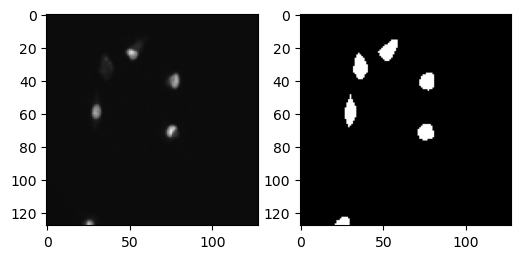

In [ ]:
ix = np.random.randint(0, len(X_test))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,4), dpi=100)
ax[0].imshow(X_test[ix])
ax[1].imshow(np.squeeze(test_pred.reshape(len(X_test), IMG_WIDTH, IMG_HEIGHT, 1)[ix]), cmap='gray');